In [ ]:
!unzip "/content/drive/MyDrive/Dataset/monkey_Dataset.zip" -d "/content/"

Archive:  /content/drive/MyDrive/Dataset/monkey_Dataset.zip
   creating: /content/training/
  inflating: /content/training/n0018.jpg  
  inflating: /content/training/n0019.jpg  
  inflating: /content/training/n0020.jpg  
  inflating: /content/training/n0021.jpg  
  inflating: /content/training/n0022.jpg  
  inflating: /content/training/n0023.jpg  
  inflating: /content/training/n0024.jpg  
  inflating: /content/training/n0025.jpg  
  inflating: /content/training/n0026.jpg  
  inflating: /content/training/n0027.jpg  
  inflating: /content/training/n0028.jpg  
  inflating: /content/training/n0029.jpg  
  inflating: /content/training/n0030.jpg  
  inflating: /content/training/n0031.jpg  
  inflating: /content/training/n0032.jpg  
  inflating: /content/training/n0033.jpg  
  inflating: /content/training/n0034.jpg  
  inflating: /content/training/n0035.jpg  
  inflating: /content/training/n0036.jpg  
  inflating: /content/training/n0037.jpg  
  inflating: /content/training/n0038.jpg  
  inf

In [ ]:
%mkdir /content/test

In [ ]:
%mv /content/validation/n918.jpg /content/validation/n916.jpg /content/validation/n914.jpg /content/validation/n913.jpg /content/test

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import re
from PIL import Image
from torch.utils.data import Dataset
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.metrics import accuracy_score
import numpy as np
import torch.nn.functional as F
import torchvision
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm import trange, tqdm
import time


In [ ]:
class Dataset(Dataset):
    catagoris = ['alouatta_palliata','erythrocebus_patas','cacajao_calvus','macaca_fuscata','cebuella_pygmea','cebus_capucinus','mico_argentatus','saimiri_sciureus','aotus_nigriceps','trachypithecus_johnii']
    def __init__(self, data_dir, transform=None):
        super(Dataset, self).__init__()
        self.data_dir = data_dir
        self.transform = transform
        lb = LabelBinarizer()
        lb.fit(self.catagoris)
        self.X, self.y = list(), list()
        for i in os.listdir(self.data_dir):
            self.X.append(i)
            str = re.search('^n\d', i)
            if str.group() == 'n0':
                self.y.append(lb.transform(['alouatta_palliata']))
                #label = 'alouatta_palliata'
            elif str.group() == 'n1':
                self.y.append(lb.transform(['erythrocebus_patas']))
                #label = 'erythrocebus_patas'
            elif str.group() == 'n2':
                self.y.append(lb.transform(['cacajao_calvus']))
                #label = 'cacajao_calvus'
            elif str.group() == 'n3':
                self.y.append(lb.transform(['macaca_fuscata']))
                #label = 'macaca_fuscata'
            elif str.group() == 'n4':
                self.y.append(lb.transform(['cebuella_pygmea']))
                #label = 'cebuella_pygmea'
            elif str.group() == 'n5':
                self.y.append(lb.transform(['cebus_capucinus']))
                #label = 'cebus_capucinus'
            elif str.group() == 'n6':
                self.y.append(lb.transform(['mico_argentatus']))
                #label = 'mico_argentatus'
            elif str.group() == 'n7':
                self.y.append(lb.transform(['saimiri_sciureus']))
                #label = 'saimiri_sciureus'
            elif str.group() == 'n8':
                self.y.append(lb.transform(['aotus_nigriceps']))
                #label = 'aotus_nigriceps'
            else:
                self.y.append(lb.transform(['trachypithecus_johnii']))
    def __getitem__(self, item):
        if self.transform:
            X = self.transform(Image.open(os.path.join(self.data_dir, self.X[item])))
        else:
            X = Image.open(os.path.join(self.data_dir, self.X[item]))
        y = self.y[item]
        Y = y.reshape(-1)
        return X, Y.astype(np.float)
    def __len__(self):
        return len(self.y)

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, kernel_size=3):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3,out_channels= 16, kernel_size=kernel_size)
        self.conv2 = nn.Conv2d(16 , out_channels= 32, kernel_size=kernel_size)
        self.conv3 = nn.Conv2d(32 , out_channels= 64, kernel_size=kernel_size)
        self.activation = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(0.6)
        self.maxpoling = nn.MaxPool2d((2, 2))
        self.flatten = nn.Flatten()
        self.dens1 = nn.Linear(57600, 128)
        self.dens2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpoling(x)
        x = self.activation(x)
        x = self.conv2(x)
        #x = self.batchnorm1(x)
        x = self.maxpoling(x)
        
        x = self.activation(x)
        x = self.conv3(x)
        #x = self.batchnorm2(x)
        x = self.maxpoling(x)
        
        x = self.activation(x)
        x = self.flatten(x)
        x = self.dens1(x)
        x = self.dropout(x)
        x = self.activation(x)
        x = self.dens2(x)
        return x

In [ ]:
larning_rate = 1e-3
batch_size = 32
load_shape = 256
target_shape = 256
loss_fn = nn.CrossEntropyLoss()
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(f'using {device} device')
model = NeuralNetwork().to(device)
optim = torch.optim.RMSprop(model.parameters(),lr=larning_rate)
transform = transforms.Compose([
    transforms.Resize((load_shape,load_shape)),
    transforms.RandomCrop((target_shape, target_shape)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

data_train = Dataset('/content/training', transform=transform)
data_val = Dataset('/content/validation', transform=transform)
data_test = Dataset('/content/test', transform=transform)

X = DataLoader(data_train, batch_size=batch_size, shuffle=True)
Y = DataLoader(data_val, batch_size=batch_size, shuffle=True)
Z = DataLoader(data_test, shuffle=True)
print(model)

def calculate_accuracy(y_pred, y):
    #top_pred = y_pred.argmax(1, keepdim=True)
    #correct = top_pred.eq(y.view_as(top_pred)).sum()
    #correct = top_pred.eq(y).sum()
  correct = (y_pred.argmax(1).to(device) == y.argmax(1).to(device)).type(torch.float).sum()
  acc = correct / y.shape[0]
  return acc
#correct += (pred.argmax(1).to(device) == lable.argmax(1).to(device)).type(torch.float).sum().item()

def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred= model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)



def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs



using cuda:0 device
NeuralNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.6, inplace=False)
  (maxpoling): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dens1): Linear(in_features=57600, out_features=128, bias=True)
  (dens2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
Train_acc, val_acc = list(), list()
Train_loss, val_loss = list(), list()

EPOCHS = 50

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, X, optim, loss_fn, device)
    valid_loss, valid_acc = evaluate(model, Y, loss_fn, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'ABOLFAZL.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    Train_acc.append(train_acc*100)
    val_acc.append(valid_acc*100)
    Train_loss.append(train_loss)
    val_loss.append(valid_loss)

Training:   0%|          | 0/35 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

Training: 100%|██████████| 35/35 [00:37<00:00,  1.23it/s]
                                                         
  2%|▏         | 1/50 [00:47<39:00, 47.77s/it]

Epoch: 01 | Epoch Time: 0m 47s
	Train Loss: 3.697 | Train Acc: 12.61%
	 Val. Loss: 2.185 |  Val. Acc: 17.71%



Training: 100%|██████████| 35/35 [00:37<00:00,  1.23it/s]
                                                         
  4%|▍         | 2/50 [01:35<38:10, 47.73s/it]

Epoch: 02 | Epoch Time: 0m 47s
	Train Loss: 2.196 | Train Acc: 21.09%
	 Val. Loss: 2.058 |  Val. Acc: 25.93%



Training: 100%|██████████| 35/35 [00:37<00:00,  1.63it/s]
                                                         
  6%|▌         | 3/50 [02:22<37:12, 47.49s/it]

Epoch: 03 | Epoch Time: 0m 47s
	Train Loss: 2.075 | Train Acc: 24.00%
	 Val. Loss: 2.056 |  Val. Acc: 24.65%



Training: 100%|██████████| 35/35 [00:37<00:00,  1.20it/s]
                                                         
  8%|▊         | 4/50 [03:09<36:11, 47.20s/it]

Epoch: 04 | Epoch Time: 0m 46s
	Train Loss: 1.881 | Train Acc: 33.54%
	 Val. Loss: 1.596 |  Val. Acc: 40.62%



Training: 100%|██████████| 35/35 [00:36<00:00,  1.19it/s]
                                                         
 10%|█         | 5/50 [03:56<35:15, 47.00s/it]

Epoch: 05 | Epoch Time: 0m 46s
	Train Loss: 1.705 | Train Acc: 37.73%
	 Val. Loss: 1.505 |  Val. Acc: 45.95%



Training: 100%|██████████| 35/35 [00:36<00:00,  1.25s/it]
                                                         
 12%|█▏        | 6/50 [04:42<34:20, 46.83s/it]

Epoch: 06 | Epoch Time: 0m 46s
	Train Loss: 1.576 | Train Acc: 44.25%
	 Val. Loss: 1.399 |  Val. Acc: 46.99%



Training: 100%|██████████| 35/35 [00:36<00:00,  1.12it/s]
                                                         
 14%|█▍        | 7/50 [05:28<33:24, 46.62s/it]

Epoch: 07 | Epoch Time: 0m 46s
	Train Loss: 1.525 | Train Acc: 45.54%
	 Val. Loss: 1.556 |  Val. Acc: 42.59%



Training: 100%|██████████| 35/35 [00:36<00:00,  1.14it/s]
                                                         
 16%|█▌        | 8/50 [06:14<32:29, 46.41s/it]

Epoch: 08 | Epoch Time: 0m 45s
	Train Loss: 1.460 | Train Acc: 49.21%
	 Val. Loss: 1.321 |  Val. Acc: 55.56%



Training: 100%|██████████| 35/35 [00:36<00:00,  1.10it/s]
                                                         
 18%|█▊        | 9/50 [07:00<31:38, 46.31s/it]

Epoch: 09 | Epoch Time: 0m 46s
	Train Loss: 1.374 | Train Acc: 50.43%
	 Val. Loss: 1.294 |  Val. Acc: 53.47%



Training: 100%|██████████| 35/35 [00:37<00:00,  1.42it/s]
                                                         
 20%|██        | 10/50 [07:47<31:02, 46.57s/it]

Epoch: 10 | Epoch Time: 0m 47s
	Train Loss: 1.300 | Train Acc: 53.93%
	 Val. Loss: 1.368 |  Val. Acc: 54.05%



Training: 100%|██████████| 35/35 [00:36<00:00,  1.11it/s]
                                                         
 22%|██▏       | 11/50 [08:34<30:14, 46.54s/it]

Epoch: 11 | Epoch Time: 0m 46s
	Train Loss: 1.232 | Train Acc: 57.34%
	 Val. Loss: 1.362 |  Val. Acc: 54.63%



Training: 100%|██████████| 35/35 [00:36<00:00,  1.08it/s]
                                                         
 24%|██▍       | 12/50 [09:20<29:28, 46.53s/it]

Epoch: 12 | Epoch Time: 0m 46s
	Train Loss: 1.158 | Train Acc: 59.75%
	 Val. Loss: 1.474 |  Val. Acc: 49.19%



Training: 100%|██████████| 35/35 [00:37<00:00,  1.33it/s]
                                                         
 26%|██▌       | 13/50 [10:07<28:40, 46.50s/it]

Epoch: 13 | Epoch Time: 0m 46s
	Train Loss: 1.129 | Train Acc: 62.52%
	 Val. Loss: 1.304 |  Val. Acc: 57.64%



Training: 100%|██████████| 35/35 [00:36<00:00,  1.41it/s]
                                                         
 28%|██▊       | 14/50 [10:53<27:54, 46.51s/it]

Epoch: 14 | Epoch Time: 0m 46s
	Train Loss: 1.064 | Train Acc: 63.32%
	 Val. Loss: 1.289 |  Val. Acc: 58.91%



Training: 100%|██████████| 35/35 [00:36<00:00,  1.11it/s]
                                                         
 30%|███       | 15/50 [11:40<27:03, 46.39s/it]

Epoch: 15 | Epoch Time: 0m 46s
	Train Loss: 1.027 | Train Acc: 64.98%
	 Val. Loss: 1.216 |  Val. Acc: 59.72%



Training: 100%|██████████| 35/35 [00:36<00:00,  1.20it/s]
                                                         
 32%|███▏      | 16/50 [12:25<26:10, 46.18s/it]

Epoch: 16 | Epoch Time: 0m 45s
	Train Loss: 0.945 | Train Acc: 67.93%
	 Val. Loss: 1.198 |  Val. Acc: 56.02%



Training: 100%|██████████| 35/35 [00:36<00:00,  1.24it/s]
                                                         
 34%|███▍      | 17/50 [13:11<25:21, 46.11s/it]

Epoch: 17 | Epoch Time: 0m 45s
	Train Loss: 0.870 | Train Acc: 71.88%
	 Val. Loss: 1.185 |  Val. Acc: 59.38%



Training: 100%|██████████| 35/35 [00:36<00:00,  1.22it/s]
                                                         
 36%|███▌      | 18/50 [13:57<24:33, 46.04s/it]

Epoch: 18 | Epoch Time: 0m 45s
	Train Loss: 0.837 | Train Acc: 70.75%
	 Val. Loss: 1.095 |  Val. Acc: 59.03%



Training: 100%|██████████| 35/35 [00:36<00:00,  1.43it/s]
                                                         
 38%|███▊      | 19/50 [14:43<23:45, 46.00s/it]

Epoch: 19 | Epoch Time: 0m 45s
	Train Loss: 0.792 | Train Acc: 71.84%
	 Val. Loss: 1.110 |  Val. Acc: 63.66%



Training: 100%|██████████| 35/35 [00:36<00:00,  1.15it/s]
                                                         
 40%|████      | 20/50 [15:29<22:57, 45.91s/it]

Epoch: 20 | Epoch Time: 0m 45s
	Train Loss: 0.721 | Train Acc: 73.29%
	 Val. Loss: 1.275 |  Val. Acc: 60.19%



Training: 100%|██████████| 35/35 [00:36<00:00,  1.11it/s]
                                                         
 42%|████▏     | 21/50 [16:15<22:16, 46.08s/it]

Epoch: 21 | Epoch Time: 0m 46s
	Train Loss: 0.731 | Train Acc: 73.70%
	 Val. Loss: 1.311 |  Val. Acc: 57.41%



Training: 100%|██████████| 35/35 [00:37<00:00,  1.17it/s]
                                                         
 44%|████▍     | 22/50 [17:02<21:40, 46.43s/it]

Epoch: 22 | Epoch Time: 0m 47s
	Train Loss: 0.710 | Train Acc: 76.70%
	 Val. Loss: 1.406 |  Val. Acc: 57.29%



Training: 100%|██████████| 35/35 [00:36<00:00,  1.07it/s]
                                                         
 46%|████▌     | 23/50 [17:49<20:54, 46.45s/it]

Epoch: 23 | Epoch Time: 0m 46s
	Train Loss: 0.558 | Train Acc: 80.30%
	 Val. Loss: 1.128 |  Val. Acc: 61.46%



Training: 100%|██████████| 35/35 [00:37<00:00,  1.16it/s]
                                                         
 48%|████▊     | 24/50 [18:36<20:14, 46.70s/it]

Epoch: 24 | Epoch Time: 0m 47s
	Train Loss: 0.534 | Train Acc: 81.37%
	 Val. Loss: 1.257 |  Val. Acc: 63.43%



Training: 100%|██████████| 35/35 [00:37<00:00,  1.13it/s]
                                                         
 50%|█████     | 25/50 [19:24<19:32, 46.92s/it]

Epoch: 25 | Epoch Time: 0m 47s
	Train Loss: 0.492 | Train Acc: 83.18%
	 Val. Loss: 1.231 |  Val. Acc: 64.70%



Training: 100%|██████████| 35/35 [00:37<00:00,  1.18it/s]
                                                         
 52%|█████▏    | 26/50 [20:11<18:47, 46.99s/it]

Epoch: 26 | Epoch Time: 0m 47s
	Train Loss: 0.483 | Train Acc: 84.18%
	 Val. Loss: 1.281 |  Val. Acc: 65.39%



Training: 100%|██████████| 35/35 [00:37<00:00,  1.26it/s]
                                                         
 54%|█████▍    | 27/50 [20:57<17:58, 46.89s/it]

Epoch: 27 | Epoch Time: 0m 46s
	Train Loss: 0.440 | Train Acc: 85.32%
	 Val. Loss: 1.366 |  Val. Acc: 62.27%



Training: 100%|██████████| 35/35 [00:37<00:00,  1.01s/it]
                                                         
 56%|█████▌    | 28/50 [21:44<17:12, 46.92s/it]

Epoch: 28 | Epoch Time: 0m 46s
	Train Loss: 0.434 | Train Acc: 85.98%
	 Val. Loss: 1.341 |  Val. Acc: 61.46%



Training: 100%|██████████| 35/35 [00:37<00:00,  1.16it/s]
                                                         
 58%|█████▊    | 29/50 [22:31<16:23, 46.85s/it]

Epoch: 29 | Epoch Time: 0m 46s
	Train Loss: 0.425 | Train Acc: 84.16%
	 Val. Loss: 1.245 |  Val. Acc: 63.89%



Training: 100%|██████████| 35/35 [00:37<00:00,  1.03it/s]
                                                         
 60%|██████    | 30/50 [23:18<15:37, 46.87s/it]

Epoch: 30 | Epoch Time: 0m 46s
	Train Loss: 0.347 | Train Acc: 88.18%
	 Val. Loss: 1.229 |  Val. Acc: 65.16%



Training: 100%|██████████| 35/35 [00:37<00:00,  1.16it/s]
                                                         
 62%|██████▏   | 31/50 [24:04<14:48, 46.75s/it]

Epoch: 31 | Epoch Time: 0m 46s
	Train Loss: 0.344 | Train Acc: 88.18%
	 Val. Loss: 1.313 |  Val. Acc: 66.90%



Training: 100%|██████████| 35/35 [00:37<00:00,  1.03it/s]
                                                         
 64%|██████▍   | 32/50 [24:51<14:02, 46.81s/it]

Epoch: 32 | Epoch Time: 0m 46s
	Train Loss: 0.347 | Train Acc: 89.46%
	 Val. Loss: 1.218 |  Val. Acc: 72.22%



Training: 100%|██████████| 35/35 [00:37<00:00,  1.46it/s]
                                                         
 66%|██████▌   | 33/50 [25:38<13:14, 46.75s/it]

Epoch: 33 | Epoch Time: 0m 46s
	Train Loss: 0.310 | Train Acc: 89.71%
	 Val. Loss: 1.321 |  Val. Acc: 62.85%



Training: 100%|██████████| 35/35 [00:37<00:00,  1.02s/it]
                                                         
 68%|██████▊   | 34/50 [26:25<12:29, 46.83s/it]

Epoch: 34 | Epoch Time: 0m 47s
	Train Loss: 0.312 | Train Acc: 89.25%
	 Val. Loss: 1.319 |  Val. Acc: 67.82%



Training: 100%|██████████| 35/35 [00:40<00:00,  1.19it/s]
                                                         
 70%|███████   | 35/50 [27:16<11:59, 47.96s/it]

Epoch: 35 | Epoch Time: 0m 50s
	Train Loss: 0.242 | Train Acc: 91.43%
	 Val. Loss: 1.318 |  Val. Acc: 68.87%



Training: 100%|██████████| 35/35 [00:37<00:00,  1.03it/s]
                                                         
 72%|███████▏  | 36/50 [28:03<11:08, 47.72s/it]

Epoch: 36 | Epoch Time: 0m 47s
	Train Loss: 0.262 | Train Acc: 91.41%
	 Val. Loss: 1.381 |  Val. Acc: 66.55%



Training: 100%|██████████| 35/35 [00:38<00:00,  1.17it/s]
                                                         
 74%|███████▍  | 37/50 [28:51<10:22, 47.85s/it]

Epoch: 37 | Epoch Time: 0m 48s
	Train Loss: 0.290 | Train Acc: 90.25%
	 Val. Loss: 1.246 |  Val. Acc: 67.36%



Training: 100%|██████████| 35/35 [00:38<00:00,  1.14it/s]
                                                         
 76%|███████▌  | 38/50 [29:39<09:36, 48.00s/it]

Epoch: 38 | Epoch Time: 0m 48s
	Train Loss: 0.230 | Train Acc: 92.82%
	 Val. Loss: 1.379 |  Val. Acc: 63.89%



Training: 100%|██████████| 35/35 [00:38<00:00,  1.15it/s]
                                                         
 78%|███████▊  | 39/50 [30:28<08:48, 48.08s/it]

Epoch: 39 | Epoch Time: 0m 48s
	Train Loss: 0.249 | Train Acc: 91.84%
	 Val. Loss: 1.402 |  Val. Acc: 67.25%



Training: 100%|██████████| 35/35 [00:38<00:00,  1.15it/s]
                                                         
 80%|████████  | 40/50 [31:16<08:02, 48.20s/it]

Epoch: 40 | Epoch Time: 0m 48s
	Train Loss: 0.245 | Train Acc: 92.46%
	 Val. Loss: 1.480 |  Val. Acc: 66.78%



Training: 100%|██████████| 35/35 [00:38<00:00,  1.13it/s]
                                                         
 82%|████████▏ | 41/50 [32:04<07:13, 48.19s/it]

Epoch: 41 | Epoch Time: 0m 48s
	Train Loss: 0.259 | Train Acc: 90.43%
	 Val. Loss: 1.539 |  Val. Acc: 66.44%



Training: 100%|██████████| 35/35 [00:39<00:00,  1.05it/s]
                                                         
 84%|████████▍ | 42/50 [32:53<06:27, 48.43s/it]

Epoch: 42 | Epoch Time: 0m 48s
	Train Loss: 0.205 | Train Acc: 92.30%
	 Val. Loss: 1.541 |  Val. Acc: 64.70%



Training: 100%|██████████| 35/35 [00:38<00:00,  1.14it/s]
                                                         
 86%|████████▌ | 43/50 [33:42<05:39, 48.46s/it]

Epoch: 43 | Epoch Time: 0m 48s
	Train Loss: 0.256 | Train Acc: 91.88%
	 Val. Loss: 1.544 |  Val. Acc: 61.92%



Training: 100%|██████████| 35/35 [00:38<00:00,  1.25it/s]
                                                         
 88%|████████▊ | 44/50 [34:30<04:50, 48.40s/it]

Epoch: 44 | Epoch Time: 0m 48s
	Train Loss: 0.201 | Train Acc: 93.64%
	 Val. Loss: 1.646 |  Val. Acc: 68.06%



Training: 100%|██████████| 35/35 [00:38<00:00,  1.07it/s]
                                                         
 90%|█████████ | 45/50 [35:18<04:02, 48.42s/it]

Epoch: 45 | Epoch Time: 0m 48s
	Train Loss: 0.149 | Train Acc: 94.54%
	 Val. Loss: 1.619 |  Val. Acc: 69.10%



Training: 100%|██████████| 35/35 [00:38<00:00,  1.04s/it]
                                                         
 92%|█████████▏| 46/50 [36:07<03:13, 48.45s/it]

Epoch: 46 | Epoch Time: 0m 48s
	Train Loss: 0.153 | Train Acc: 95.09%
	 Val. Loss: 1.437 |  Val. Acc: 70.25%



Training: 100%|██████████| 35/35 [00:38<00:00,  1.07it/s]
                                                         
 94%|█████████▍| 47/50 [36:55<02:25, 48.45s/it]

Epoch: 47 | Epoch Time: 0m 48s
	Train Loss: 0.214 | Train Acc: 92.93%
	 Val. Loss: 2.307 |  Val. Acc: 53.36%



Training: 100%|██████████| 35/35 [00:39<00:00,  1.27it/s]
                                                         
 96%|█████████▌| 48/50 [37:45<01:37, 48.67s/it]

Epoch: 48 | Epoch Time: 0m 49s
	Train Loss: 0.199 | Train Acc: 93.38%
	 Val. Loss: 1.712 |  Val. Acc: 64.81%



Training: 100%|██████████| 35/35 [00:38<00:00,  1.22it/s]
                                                         
 98%|█████████▊| 49/50 [38:33<00:48, 48.70s/it]

Epoch: 49 | Epoch Time: 0m 48s
	Train Loss: 0.120 | Train Acc: 95.71%
	 Val. Loss: 1.751 |  Val. Acc: 65.86%



Training: 100%|██████████| 35/35 [00:38<00:00,  1.08s/it]
                                                         
100%|██████████| 50/50 [39:22<00:00, 47.25s/it]

Epoch: 50 | Epoch Time: 0m 48s
	Train Loss: 0.178 | Train Acc: 94.02%
	 Val. Loss: 1.439 |  Val. Acc: 66.32%


In [ ]:
x = [i+1 for i in range(EPOCHS)]

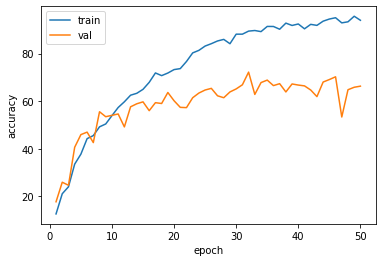

In [ ]:
plt.plot(np.array(x), np.array(Train_acc), label = 'train')
plt.plot(np.array(x), np.array(val_acc), label = 'val')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

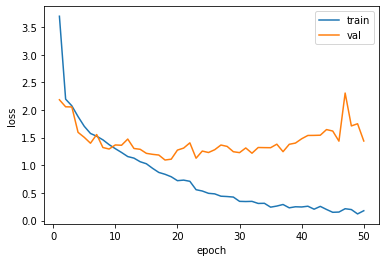

In [ ]:
plt.plot(np.array(x), np.array(Train_loss), label = 'train')
plt.plot(np.array(x), np.array(val_loss), label = 'val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
model.load_state_dict(torch.load('ABOLFAZL.pt'))

test_loss, test_acc = evaluate(model, Z, loss_fn, device)

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.892 | Test Acc: 75.00%
